# Sparsity measures, 1D

In [18]:
import copy
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split
from mpl_toolkits.axes_grid1 import make_axes_locatable

import nelpy as nel
import nelpy.plotting as npl

# load extra functionality
import nelpy.hmmutils
import nelpy.plotting.graph as npx

from nelpy.analysis.hmm_sparsity import HMMSurrogate

npl.setup(font_scale=1)

%matplotlib inline

warnings.filterwarnings("ignore")

# Note: we use https://github.com/sbordt/markovmixing.git for Markov chain mixing times (Python 2 though, so maybe not?)
# NOTE: see http://www.statslab.cam.ac.uk/~beresty/teach/Mixing/mixing3.pdf for theoretical treatment of spectral gap, mixing times, etc.

In [31]:
import pandas as pd
a = pd.read_csv('/home/etienne/Downloads/transmat.csv', header=None)
transmat = np.array(a)

br = score_bottleneck_ratio(transmat)

print(br)

0.19113828594149659

In [25]:
def score_bottleneck_ratio(transmat, n_samples=50000, verbose=False):
    from nelpy.analysis.ergodic import steady_state
    def Qij(i, j, P, pi):
        return pi[i] * P[i,j]

    def QAB(A, B, P, pi):
        sumQ = 0
        for i in A:
            for j in B:
                sumQ += Qij(i, j, P, pi)
        return sumQ

    def complement(S, Omega):
        return Omega - S

    def Pi(S, pi):
        sumS = 0
        for i in S:
            sumS += pi[i]
        return sumS

    def Phi(S, P, pi, Omega):
        Sc = complement(S, Omega)
        return QAB(S, Sc, P, pi) / Pi(S, pi)

    P = transmat
    num_states = transmat.shape[0]
    Omega = set(range(num_states))
    pi_ = steady_state(P).real

    min_Phi = 1
    for nn in range(n_samples):
        n_samp_in_subset = np.random.randint(1, num_states-1)
        S = set(np.random.choice(num_states, n_samp_in_subset, replace=False))
        while Pi(S, pi_) > 0.5:
            n_samp_in_subset -=1
            if n_samp_in_subset < 1:
                n_samp_in_subset = 1
            S = set(np.random.choice(num_states, n_samp_in_subset, replace=False))
        candidate_Phi = Phi(S, P, pi_, Omega)
        if candidate_Phi < min_Phi:
            min_Phi = candidate_Phi
            if verbose:
                print("{}: {} (|S| = {})".format(nn, min_Phi, len(S)))
    return min_Phi

## Load data

In [2]:
datadirs = ['/home/etienne/Dropbox/neoReader/',
            'C:/Etienne/Dropbox/neoReader/',
            'D:/Dropbox/neoReader/']

fileroot = next( (dir for dir in datadirs if os.path.isdir(dir)), None)

if fileroot is None:
    raise FileNotFoundError('datadir not found')

load_from_nel = True

# loaf from nel file:
if load_from_nel:
    jar = nel.load_pkl(fileroot + 'gor01_all_processed.nel')
    df = jar.df
    exp_data = jar.exp_data
    aux_data = jar.aux_data
    del jar

## Set experimental parameters

In [7]:
num_states = 30 # number of states for PBE HMM
ds = 0.02 # 20 ms bin size for PBEs
ds_tc = 0.25 # 250 ms time bin for estimating tuning curves for Bayesian decoding
min_tc_duration = 0 # mininmum observation time in seconds, before a bin contributes to the tuning curve
sigma_tc = 4 # 4 cm smoothing on tuning curves
test_size = 0.2
random_state = 1
verbose = False

n_shuffles = 250

# build crude sessions list:
gor_sessions = []
for session in aux_data:
    segments = list(aux_data[session].keys())
    for segment in segments:
        gor_sessions.append((session, segment))

session_time = '16-40-19'; segment = 'short'

description = (session_time, segment)

# get spike train
st = exp_data[session_time]['spikes']
# restrict spikes to only PBEs:
mua_spks = st[aux_data[session_time][segment]['PBEs'].support]

In [9]:
gor_sessions

[('16-53-46', 'short'),
 ('16-53-46', 'long'),
 ('15-22-3', 'short'),
 ('15-22-3', 'long'),
 ('14-42-6', 'short'),
 ('14-42-6', 'long'),
 ('21-16-25', 'short'),
 ('21-16-25', 'long'),
 ('11-26-53', 'short'),
 ('11-26-53', 'long'),
 ('15-55-31', 'short'),
 ('15-55-31', 'long'),
 ('22-24-40', 'short'),
 ('22-24-40', 'long'),
 ('1-22-43', 'short'),
 ('1-22-43', 'long'),
 ('16-40-19', 'short'),
 ('16-40-19', 'long'),
 ('3-23-37', 'long'),
 ('15-46-47', 'long')]

In [5]:
datadirs = ['/home/etienne/Dropbox/work/nel jars/',
            'C:/Etienne/Dropbox/neoReader/',
            'D:/Dropbox/neoReader/']

fileroot = next( (dir for dir in datadirs if os.path.isdir(dir)), None)

if fileroot is None:
    raise FileNotFoundError('datadir not found')

load_from_nel = True

# loaf from nel file:
if load_from_nel:
    jar = nel.load_pkl(fileroot + 'gini_bottle_N250_DibaBuzsaki_gor01.nel')
    hmms = jar.hmms
    del jar

In [143]:
def figure_layout(fig):
    import matplotlib.gridspec as gridspec
    
    axes = []
    
    gs = gridspec.GridSpec(3, 1, height_ratios=[1, 1, 1])
#     gs.update(left=0.05, right=0.95)

    gs0 = gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=gs[0], wspace=0.1)
    gs1 = gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=gs[1], wspace=0.1)
    gs2 = gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=gs[2], wspace=0.1)
    
    axes.append(fig.add_subplot(gs0[0]))
    axes.append(fig.add_subplot(gs0[1]))
    axes.append(fig.add_subplot(gs0[2]))
    axes.append(fig.add_subplot(gs0[3]))
    
    axes.append(fig.add_subplot(gs1[0]))
    axes.append(fig.add_subplot(gs1[1]))
    axes.append(fig.add_subplot(gs1[2]))
    axes.append(fig.add_subplot(gs1[3]))
    
    axes.append(fig.add_subplot(gs2[0]))
    axes.append(fig.add_subplot(gs2[1]))
    axes.append(fig.add_subplot(gs2[2]))
    axes.append(fig.add_subplot(gs2[3]))
        
    return axes

import numpy.linalg as LA

def spectral_gap(transmat):
    evals = LA.eigvals(transmat)
    sorder = np.argsort(np.abs(evals))
    gap = np.real(evals[sorder[-1]] - np.abs(evals[sorder[-2]]))
    return gap

class ColorBarLocator(object):
    def __init__(self, pax, pad=5, width=10):
        self.pax = pax
        self.pad = pad
        self.width = width

    def __call__(self, ax, renderer):
        x, y, w, h = self.pax.get_position().bounds
        fig = self.pax.get_figure()
        inv_trans = fig.transFigure.inverted()
        pad, _ = inv_trans.transform([self.pad, 0])
        width, _ = inv_trans.transform([self.width, 0])
        return [x+w+pad, y, width, h]

def plot_transmat(ax, hmm, edge_threshold=0.0, title='', cbar=True, ylabel=True, **fig_kws):
    cmap = fig_kws.get('cmap', plt.cm.viridis)
    
    num_states = hmm.hmm.n_components
    
    img = ax.matshow(np.where(hmm.hmm.transmat>edge_threshold, hmm.hmm.transmat, 0), cmap=cmap, vmin=0, vmax=1, interpolation='none', aspect='equal')
    ax.set_aspect('equal')
    
    if cbar:
        divider = make_axes_locatable(ax)
#         cax = divider.append_axes("right", size=0.1, pad=0.1)
        cax = fig.add_axes([0,0,0,0], axes_locator=ColorBarLocator(ax))
        cb=plt.colorbar(img, cax=cax)
        cb.set_label('probability', labelpad=-8)
        cb.set_ticks([0,1])
        npl.utils.no_ticks(cax)
        
#     if not cbar:
#         cax.set_visible(False)
    if ylabel:
        ax.set_yticks([0.5, num_states-1.5])
        ax.set_yticklabels(['1', str(num_states)])    
        ax.set_ylabel('state $i$', labelpad=-16)
    else:
        ax.set_yticks([])
        ax.set_yticklabels('')
    
    ax.set_xticks([0.5, num_states-1.5])
    ax.set_xticklabels(['1', str(num_states)])
    ax.set_xbound(lower=0.0, upper=num_states-1)
    ax.set_ybound(lower=0.0, upper=num_states-1)
    
    ax.set_xlabel('state $j$', labelpad=-16)
    
    ax.set_title(title + ' A')
    sns.despine(ax=ax)    
    
def plot_lambda(ax, hmm, cbar=True, ylabel=True, title='', lo=None, **fig_kws):
    cmap = fig_kws.get('cmap', plt.cm.viridis)
    
    num_states = hmm.hmm.n_components
    num_units = hmm.hmm.n_features
    
    if lo is not None:
        img = ax.matshow(hmm.hmm.means[:,lo].T, cmap=cmap, interpolation='none', aspect='auto')
    else:
        img = ax.matshow(hmm.hmm.means.T, cmap=cmap, interpolation='none', aspect='auto')
    
    if cbar:
        divider = make_axes_locatable(ax)
        cax = fig.add_axes([0,0,0,0], axes_locator=ColorBarLocator(ax))
        cax = divider.append_axes("right", size=0.1, pad=0.1)
        cb=plt.colorbar(img, cax=cax)
        cb.set_label('firing rate', labelpad=-8)
#         cb.set_ticks([0,1])
        cb.set_ticklabels(['lo', 'hi'])
        npl.utils.no_ticks(cax)
    
    if ylabel:
        ax.set_yticks([0.5, num_units-1.5])
        ax.set_yticklabels(['1', str(num_units)])
        ax.set_ylabel('unit', labelpad=-16)
    else:
        ax.set_yticks([])
        ax.set_yticklabels('')
        
    ax.set_xticks([0.5, num_states-1.5])
    ax.set_xticklabels(['1', str(num_states)])    
    
    ax.set_ybound(lower=0.0, upper=num_units-1)
    ax.set_xbound(lower=0.0, upper=num_states-1)
    
    ax.set_xlabel('state', labelpad=-16)
    ax.set_title(title + ' $\Lambda$')
    sns.despine(ax=ax)   
    ax.set_aspect(num_states/num_units)
    
def plot_sun_graph(ax, hmm, edge_threshold=0.0, lw=2, ec='k', nc='k', node_size=3, **fig_kws):
    plt.sca(ax)
    
    Gi = npx.inner_graph_from_transmat(hmm.hmm.transmat)
    Go = npx.outer_graph_from_transmat(hmm.hmm.transmat)
    
    npx.draw_transmat_graph_inner(Gi, edge_threshold=edge_threshold, lw=lw, ec=ec, node_size=node_size)
    npx.draw_transmat_graph_outer(Go, Gi, edge_threshold=edge_threshold, lw=lw, ec=ec, nc=nc, node_size=node_size*2)

    ax.set_xlim(-1.4,1.4)
    ax.set_ylim(-1.4,1.4)
#     ax0, img = npl.imagesc(hmm.transmat, ax=axes[0])
    npl.utils.clear_left_right(ax)
    npl.utils.clear_top_bottom(ax)
    
#     ax.set_title('1 - $|\lambda_2| =$ {0:.2f}'.format(float(spectral_gap(hmm.hmm.transmat))))
    ax.set_title('$\gamma^*=$ {0:.3f}'.format(float(spectral_gap(hmm.hmm.transmat))), y=1.02)
    
    ax.set_aspect('equal')
    
def plot_connectivity_graph(ax, hmm, edge_threshold=0.0, lw=2, ec='k', node_size=3, **fig_kws):
    plt.sca(ax)
    
    G = npx.graph_from_transmat(hmm.hmm.transmat)
    
    npx.draw_transmat_graph(G, edge_threshold=edge_threshold, lw=lw, ec=ec, node_size=node_size)
#     ax.set_xlim(-1.3,1.3)
#     ax.set_ylim(-1.3,1.3)
    ax.set_xlim(-1,1)
    ax.set_ylim(-1,1)
#     ax0, img = npl.imagesc(hmm.transmat, ax=axes[0])
    npl.utils.clear_left_right(ax)
    npl.utils.clear_top_bottom(ax)
    ax1.set_aspect('equal')
    
def plot_transmat_gini_departure(ax, hmms, n_max=500, **fig_kws):
    
    hist_kws={"range": (0.5, 1)}
    bins=50

    for hmm in hmms:
        data = np.array(hmm.results['gini_tmat_departure'])
        data = data[:n_max,:]
        sns.distplot(data.sum(axis=0)/len(data), hist=False, hist_kws=hist_kws, bins=bins, label=hmm.label, ax=ax)

    ax.set_title('tmat gini departure, N=250')
    
    ax.set_xlim(0.6, 0.9)
    
    sns.despine(ax=ax)
    
def plot_transmat_gini_arrival(ax, hmms, n_max=500, **fig_kws):
    
    hist_kws={"range": (0.8, 1)}
    bins=50

    for hmm in hmms:
        data = np.array(hmm.results['gini_tmat_arrival'])
        data = data[:n_max,:]
        sns.distplot(data.sum(axis=0)/len(data), hist=False, hist_kws=hist_kws, bins=bins, label=hmm.label, ax=ax)

    ax.set_title('tmat gini arrival, N=250')
    ax.legend('')
    ax.set_xlim(0.7, 1)
    
    sns.despine(ax=ax)
    
def plot_bottleneck(ax, hmms, n_max=500, **fig_kws):
    
    hist_kws={"range": (0, 0.5)}
    bins=50

    for hmm in hmms:
        data = np.array(hmm.results['bottleneck'])
        data = data[:n_max]
        sns.distplot(data, hist=False, hist_kws=hist_kws, bins=bins, label=hmm.label, ax=ax)

    ax.set_title('bottleneck, N=250')
    
    ax.legend('')
    
    ax.set_xlim(0, 0.5)
    
    sns.despine(ax=ax)
    
def plot_gini_lambda(ax, hmms, n_max=500, **fig_kws):
    
    hist_kws={"range": (0.7, 0.9)}
    bins=50

    for hmm in hmms:
        data = np.array(hmm.results['gini_lambda'])
        data = data[:n_max]
        sns.distplot(data, hist=False, hist_kws=hist_kws, bins=bins, label=hmm.label, ax=ax)

    ax.set_title('lambda gini, N=250')
    ax.legend('')
    ax.set_xlim(0.7, 0.9)
    
    sns.despine(ax=ax)
    
def plot_lambda_gini_across_states(ax, hmms, n_max=5000, **fig_kws):
    
    hist_kws={"range": (0.0, 1)}
    bins=30

    for hmm in hmms:
        data = np.array(hmm.results['gini_lambda_across_states'])
        data = data[:n_max,:]
        sns.distplot(data.sum(axis=0)/len(data), hist_kws=hist_kws, bins=bins, hist=False, kde=True, label=hmm.label, ax=ax, kde_kws={'bw':0.05})
    
    ax.set_title('lambda gini across states, N=250')
    ax.legend('')
    ax.set_xlim(0., 1)
    
    sns.despine(ax=ax)



pdf saved successfully...
png saved successfully...
svg saved successfully...


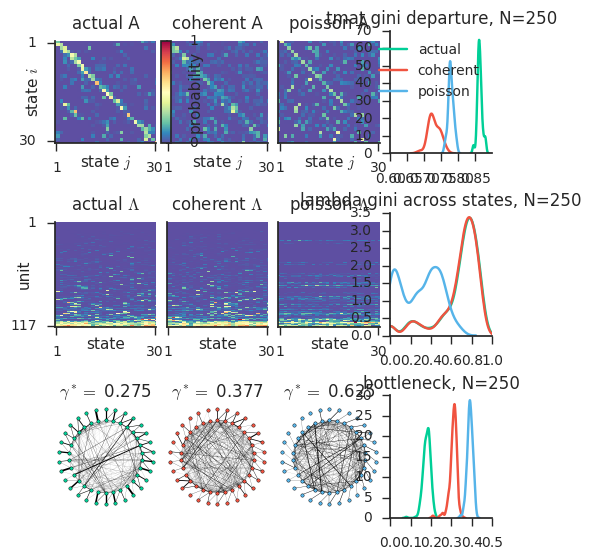

In [149]:
fig = plt.figure(1, figsize=(6, 6))
# fig = plt.figure(1, figsize=(16, 14))

lambda_order = np.argsort(hmms[0].hmm.means.sum(axis=0))
# plt.matshow(hmm.means[:,no].T, cmap=plt.cm.Spectral_r)

## define the figure layout
axes = figure_layout(fig)

## define figure parameters and color pallete
text_kws = dict(ha="center", size=7)
fig_kws = dict(text_kws=text_kws, cmap=plt.cm.Spectral_r)

# ## plot the various panels
plot_transmat(axes[0], hmm=hmms[0], title=hmms[0].label, cbar=True, **fig_kws)
# plot_transmat(axes[1], hmm=hmms[1], title=hmms[1].label, cbar=False, ylabel=False, **fig_kws)
plot_transmat(axes[1], hmm=hmms[2], title=hmms[2].label, cbar=False, ylabel=False, **fig_kws)
plot_transmat(axes[2], hmm=hmms[3], title=hmms[3].label, cbar=False, ylabel=False, **fig_kws)
# plot_transmat(axes[4], hmm=hmms[4], title=hmms[4].label, cbar=False, ylabel=False, **fig_kws)
# plot_transmat(axes[5], hmm=hmms[5], title=hmms[5].label, cbar=True, ylabel=False, **fig_kws)

plot_sun_graph(axes[8], hmm=hmms[0], nc=npl.colors.sweet.green, **fig_kws)
# plot_sun_graph(axes[7], hmm=hmms[1], nc=npl.colors.sweet.red, **fig_kws)
plot_sun_graph(axes[9], hmm=hmms[2], nc=npl.colors.sweet.red, **fig_kws)
plot_sun_graph(axes[10], hmm=hmms[3], nc=npl.colors.sweet.blue, **fig_kws)
# plot_sun_graph(axes[10], hmm=hmms[4], nc=npl.colors.sweet.purple, **fig_kws)
# plot_sun_graph(axes[11], hmm=hmms[5], nc=npl.colors.sweet.maroon, **fig_kws)

plot_lambda(axes[4], hmm=hmms[0], title=hmms[0].label, cbar=False, lo=lambda_order, **fig_kws)
# plot_lambda(axes[13], hmm=hmms[1], title=hmms[1].label, ylabel=False, cbar=False,**fig_kws)
plot_lambda(axes[5], hmm=hmms[2], title=hmms[2].label, ylabel=False, lo=lambda_order, cbar=False,**fig_kws)
plot_lambda(axes[6], hmm=hmms[3], title=hmms[3].label, ylabel=False, lo=lambda_order, cbar=False,**fig_kws)
# plot_lambda(axes[16], hmm=hmms[4], title=hmms[4].label, ylabel=False, cbar=False, **fig_kws)
# plot_lambda(axes[17], hmm=hmms[5], title=hmms[5].label, ylabel=False, cbar=False, **fig_kws)

plot_transmat_gini_departure(axes[3], [hmms[0], hmms[2], hmms[3]], **fig_kws)
# plot_transmat_gini_arrival(axes[19], hmms, **fig_kws)
plot_lambda_gini_across_states(axes[7], [hmms[0], hmms[2], hmms[3]], **fig_kws)
# plot_gini_lambda(axes[7], [hmms[0], hmms[2], hmms[3]], **fig_kws)
plot_bottleneck(axes[11], [hmms[0], hmms[2], hmms[3]], **fig_kws)

# plot_obsmat(axes[1], **fig_kws)

# ## label the panels
# label_panels(fig, size=18)

fig.tight_layout(h_pad=.5, w_pad=0.75, rect=[0, .05, 1, 1])
# fig.tight_layout()

# npl.savefig('b_sparsity', formats=['pdf', 'png', 'svg'])

# Repeat computations for above results

# Define HMM surrogate analysis objects

In [22]:
hmm_actual = HMMSurrogate(kind='actual', 
                          st=mua_spks, 
                          num_states=num_states, 
                          ds=ds, 
                          test_size=test_size, 
                          random_state=random_state, 
                          description=description,
                          verbose=verbose)

hmm_incoherent = HMMSurrogate(kind='incoherent', 
                                       st=mua_spks, 
                                       num_states=num_states, 
                                       ds=ds, 
                                       test_size=test_size, 
                                       random_state=random_state, 
                                       description=description,
                                       verbose=verbose)

hmm_coherent = HMMSurrogate(kind='coherent', 
                                       st=mua_spks, 
                                       num_states=num_states, 
                                       ds=ds, 
                                       test_size=test_size, 
                                       random_state=random_state, 
                                       description=description,
                                       verbose=verbose)

hmm_poisson = HMMSurrogate(kind='poisson', 
                                       st=mua_spks, 
                                       num_states=num_states, 
                                       ds=ds, 
                                       test_size=test_size, 
                                       random_state=random_state, 
                                       description=description,
                                       verbose=verbose)

hmm_unit_id = HMMSurrogate(kind='unit_id', 
                                       st=mua_spks, 
                                       num_states=num_states, 
                                       ds=ds, 
                                       test_size=test_size, 
                                       random_state=random_state, 
                                       description=description,
                                       verbose=verbose)

hmm_spike_id = HMMSurrogate(kind='spike_id', 
                                       st=mua_spks, 
                                       num_states=num_states, 
                                       ds=ds, 
                                       test_size=test_size, 
                                       random_state=random_state, 
                                       description=description,
                                       verbose=verbose)

hmms = [hmm_actual,
        hmm_incoherent,
        hmm_coherent,
        hmm_poisson,
        hmm_unit_id,
        hmm_spike_id]

In [23]:
for hmm in hmms:
    hmm.clear_results()

In [24]:
for nn in range(n_shuffles):
    print('starting {}'.format(nn))
    for hmm in hmms:
        print("shuffling", hmm.label)
        hmm.shuffle()
        print("fitting", hmm.label)
        hmm.fit()
        print("scoring", hmm.label)
        
        # calculate and aggregate various gini coefficients
        hmm.score_gini(kind='tmat')
        hmm.score_gini(kind='lambda')
        hmm.score_gini(kind='tmat_arrival')
        hmm.score_gini(kind='tmat_departure')
        hmm.score_gini(kind='lambda_across_states')
        hmm.score_gini(kind='lambda_across_units')
        
        # calculate and aggregate bottleneck_ratios
        hmm.score_bottleneck_ratio(n_samples=20000)
        
    print('completed {}'.format(nn))

        # calculate and aggregate mixing time

        # calculate and aggregate spectrum (or are we only interedted in lambda2 and spectral gap?)

starting 0
shuffling actual
fitting actual
scoring actual
shuffling incoherent
fitting incoherent
scoring incoherent
shuffling coherent
fitting coherent
scoring coherent
shuffling poisson
fitting poisson
scoring poisson
shuffling unit_id
fitting unit_id
scoring unit_id
shuffling spike_id
fitting spike_id
scoring spike_id
completed 0
starting 1
shuffling actual
fitting actual
scoring actual
shuffling incoherent
fitting incoherent
scoring incoherent
shuffling coherent
fitting coherent
scoring coherent
shuffling poisson
fitting poisson
scoring poisson
shuffling unit_id
fitting unit_id
scoring unit_id
shuffling spike_id
fitting spike_id
scoring spike_id
completed 1
starting 2
shuffling actual
fitting actual
scoring actual
shuffling incoherent
fitting incoherent
scoring incoherent
shuffling coherent
fitting coherent
scoring coherent
shuffling poisson
fitting poisson
scoring poisson
shuffling unit_id
fitting unit_id
scoring unit_id
shuffling spike_id
fitting spike_id
scoring spike_id
complet

In [25]:
jar = nel.ResultsContainer(hmms=hmms, description='N=250 bottle and gini measures on DibaBuzsaki gor01.')
# jar.save_pkl('gini_bottle_N250_DibaBuzsaki_gor01.nel')

In [50]:
def figure_layout(fig):
    import matplotlib.gridspec as gridspec
    
    axes = []
    
    gs = gridspec.GridSpec(4, 1, height_ratios=[1, 1, 1, 1])
#     gs.update(left=0.05, right=0.95)

    gs0 = gridspec.GridSpecFromSubplotSpec(1, 6, subplot_spec=gs[0], wspace=0.1)
    gs1 = gridspec.GridSpecFromSubplotSpec(1, 6, subplot_spec=gs[1], wspace=0.1)
    gs2 = gridspec.GridSpecFromSubplotSpec(1, 6, subplot_spec=gs[2], wspace=0.1)
    gs3 = gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=gs[3], width_ratios=[0.2, 0.2, 0.2, 0.2], wspace=0.2)
    
    axes.append(fig.add_subplot(gs0[0]))
    axes.append(fig.add_subplot(gs0[1]))
    axes.append(fig.add_subplot(gs0[2]))
    axes.append(fig.add_subplot(gs0[3]))
    axes.append(fig.add_subplot(gs0[4]))
    axes.append(fig.add_subplot(gs0[5]))

    axes.append(fig.add_subplot(gs1[0]))
    axes.append(fig.add_subplot(gs1[1]))
    axes.append(fig.add_subplot(gs1[2]))
    axes.append(fig.add_subplot(gs1[3]))
    axes.append(fig.add_subplot(gs1[4]))
    axes.append(fig.add_subplot(gs1[5]))

    axes.append(fig.add_subplot(gs2[0]))
    axes.append(fig.add_subplot(gs2[1]))
    axes.append(fig.add_subplot(gs2[2]))
    axes.append(fig.add_subplot(gs2[3]))
    axes.append(fig.add_subplot(gs2[4]))
    axes.append(fig.add_subplot(gs2[5]))
    
    axes.append(fig.add_subplot(gs3[0]))
    axes.append(fig.add_subplot(gs3[1]))
    axes.append(fig.add_subplot(gs3[2]))
    axes.append(fig.add_subplot(gs3[3]))
            
    return axes

import numpy.linalg as LA

def spectral_gap(transmat):
    evals = LA.eigvals(transmat)
    sorder = np.argsort(np.abs(evals))
    gap = np.real(evals[sorder[-1]] - np.abs(evals[sorder[-2]]))
    return gap

class ColorBarLocator(object):
    def __init__(self, pax, pad=5, width=10):
        self.pax = pax
        self.pad = pad
        self.width = width

    def __call__(self, ax, renderer):
        x, y, w, h = self.pax.get_position().bounds
        fig = self.pax.get_figure()
        inv_trans = fig.transFigure.inverted()
        pad, _ = inv_trans.transform([self.pad, 0])
        width, _ = inv_trans.transform([self.width, 0])
        return [x+w+pad, y, width, h]

def plot_transmat(ax, hmm, edge_threshold=0.0, title='', cbar=True, ylabel=True, **fig_kws):
    cmap = fig_kws.get('cmap', plt.cm.viridis)
    
    num_states = hmm.hmm.n_components
    
    img = ax.matshow(np.where(hmm.hmm.transmat>edge_threshold, hmm.hmm.transmat, 0), cmap=cmap, vmin=0, vmax=1, interpolation='none', aspect='equal')
    ax.set_aspect('equal')
    
    if cbar:
        divider = make_axes_locatable(ax)
#         cax = divider.append_axes("right", size=0.1, pad=0.1)
        cax = fig.add_axes([0,0,0,0], axes_locator=ColorBarLocator(ax))
        cb=plt.colorbar(img, cax=cax)
        cb.set_label('probability', labelpad=-8)
        cb.set_ticks([0,1])
        npl.utils.no_ticks(cax)
        
#     if not cbar:
#         cax.set_visible(False)
    if ylabel:
        ax.set_yticks([0.5, num_states-1.5])
        ax.set_yticklabels(['1', str(num_states)])    
        ax.set_ylabel('state $i$', labelpad=-16)
    else:
        ax.set_yticks([])
        ax.set_yticklabels('')
    
    ax.set_xticks([0.5, num_states-1.5])
    ax.set_xticklabels(['1', str(num_states)])
    ax.set_xbound(lower=0.0, upper=num_states-1)
    ax.set_ybound(lower=0.0, upper=num_states-1)
    
    ax.set_xlabel('state $j$', labelpad=-16)
    
    ax.set_title(title + ' A')
    sns.despine(ax=ax)    
    
def plot_lambda(ax, hmm, cbar=True, ylabel=True, title='', **fig_kws):
    cmap = fig_kws.get('cmap', plt.cm.viridis)
    
    num_states = hmm.hmm.n_components
    num_units = hmm.hmm.n_features
    
    img = ax.matshow(hmm.hmm.means.T, cmap=cmap, interpolation='none', aspect='auto')
    
    
    if cbar:
        divider = make_axes_locatable(ax)
        cax = fig.add_axes([0,0,0,0], axes_locator=ColorBarLocator(ax))
        cax = divider.append_axes("right", size=0.1, pad=0.1)
        cb=plt.colorbar(img, cax=cax)
        cb.set_label('firing rate', labelpad=-8)
#         cb.set_ticks([0,1])
        cb.set_ticklabels(['lo', 'hi'])
        npl.utils.no_ticks(cax)
    
    if ylabel:
        ax.set_yticks([0.5, num_units-1.5])
        ax.set_yticklabels(['1', str(num_units)])
        ax.set_ylabel('unit', labelpad=-16)
    else:
        ax.set_yticks([])
        ax.set_yticklabels('')
        
    ax.set_xticks([0.5, num_states-1.5])
    ax.set_xticklabels(['1', str(num_states)])    
    
    ax.set_ybound(lower=0.0, upper=num_units-1)
    ax.set_xbound(lower=0.0, upper=num_states-1)
    
    ax.set_xlabel('state', labelpad=-16)
    ax.set_title(title + ' $\Lambda$')
    sns.despine(ax=ax)   
    ax.set_aspect(num_states/num_units)
    
def plot_sun_graph(ax, hmm, edge_threshold=0.0, lw=2, ec='k', nc='k', node_size=3, **fig_kws):
    plt.sca(ax)
    
    Gi = npx.inner_graph_from_transmat(hmm.hmm.transmat)
    Go = npx.outer_graph_from_transmat(hmm.hmm.transmat)
    
    npx.draw_transmat_graph_inner(Gi, edge_threshold=edge_threshold, lw=lw, ec=ec, node_size=node_size)
    npx.draw_transmat_graph_outer(Go, Gi, edge_threshold=edge_threshold, lw=lw, ec=ec, nc=nc, node_size=node_size*2)

    ax.set_xlim(-1.4,1.4)
    ax.set_ylim(-1.4,1.4)
#     ax0, img = npl.imagesc(hmm.transmat, ax=axes[0])
    npl.utils.clear_left_right(ax)
    npl.utils.clear_top_bottom(ax)
    
#     ax.set_title('1 - $|\lambda_2| =$ {0:.2f}'.format(float(spectral_gap(hmm.hmm.transmat))))
    ax.set_title('$\gamma^*=$ {0:.3f}'.format(float(spectral_gap(hmm.hmm.transmat))), y=1.02)
    
    ax.set_aspect('equal')
    
def plot_connectivity_graph(ax, hmm, edge_threshold=0.0, lw=2, ec='k', node_size=3, **fig_kws):
    plt.sca(ax)
    
    G = npx.graph_from_transmat(hmm.hmm.transmat)
    
    npx.draw_transmat_graph(G, edge_threshold=edge_threshold, lw=lw, ec=ec, node_size=node_size)
#     ax.set_xlim(-1.3,1.3)
#     ax.set_ylim(-1.3,1.3)
    ax.set_xlim(-1,1)
    ax.set_ylim(-1,1)
#     ax0, img = npl.imagesc(hmm.transmat, ax=axes[0])
    npl.utils.clear_left_right(ax)
    npl.utils.clear_top_bottom(ax)
    ax1.set_aspect('equal')
    
def plot_transmat_gini_departure(ax, hmms, n_max=500, **fig_kws):
    
    hist_kws={"range": (0.8, 1)}
    bins=50

    for hmm in hmms:
        data = np.array(hmm.results['gini_tmat_departure'])
        data = data[:n_max,:]
        sns.distplot(data.sum(axis=0)/len(data), hist=False, hist_kws=hist_kws, bins=bins, label=hmm.label, ax=ax)

    ax.set_title('tmat gini departure, N=250')
    
    ax.set_xlim(0.7, 1)
    
    sns.despine(ax=ax)
    
def plot_transmat_gini_arrival(ax, hmms, n_max=500, **fig_kws):
    
    hist_kws={"range": (0.8, 1)}
    bins=50

    for hmm in hmms:
        data = np.array(hmm.results['gini_tmat_arrival'])
        data = data[:n_max,:]
        sns.distplot(data.sum(axis=0)/len(data), hist=False, hist_kws=hist_kws, bins=bins, label=hmm.label, ax=ax)

    ax.set_title('tmat gini arrival, N=250')
    ax.legend('')
    ax.set_xlim(0.7, 1)
    
    sns.despine(ax=ax)
    
def plot_bottleneck(ax, hmms, n_max=500, **fig_kws):
    
    hist_kws={"range": (0, 0.5)}
    bins=50

    for hmm in hmms:
        data = np.array(hmm.results['bottleneck'])
        data = data[:n_max]
        sns.distplot(data, hist=False, hist_kws=hist_kws, bins=bins, label=hmm.label, ax=ax)

    ax.set_title('bottleneck, N=250')
    
    ax.legend('')
    
    ax.set_xlim(0, 0.5)
    
    sns.despine(ax=ax)
    
def plot_gini_lambda(ax, hmms, n_max=500, **fig_kws):
    
    hist_kws={"range": (0.3, 1.0)}
    bins=50

    for hmm in hmms:
        data = np.array(hmm.results['gini_lambda'])
        data = data[:n_max]
        sns.distplot(data, hist=False, hist_kws=hist_kws, bins=bins, label=hmm.label, ax=ax)

    ax.set_title('lambda gini, N=250')
    ax.legend('')
    ax.set_xlim(0.3, 1.0)
    
    sns.despine(ax=ax)
    


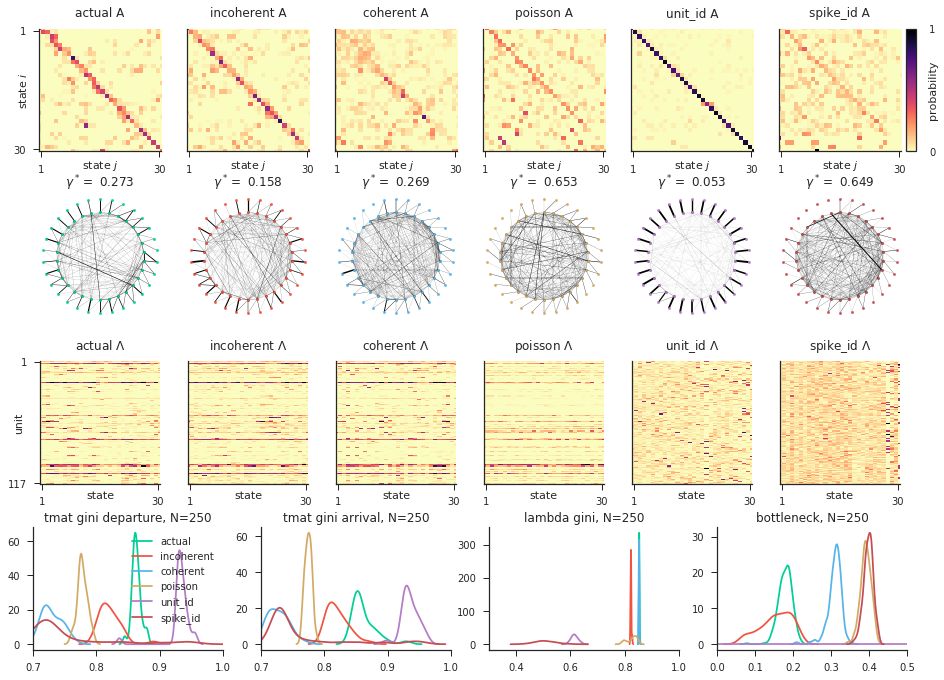

In [75]:
fig = plt.figure(1, figsize=(13, 10))
# fig = plt.figure(1, figsize=(16, 14))

## define the figure layout
axes = figure_layout(fig)

## define figure parameters and color pallete
text_kws = dict(ha="center", size=7)
fig_kws = dict(text_kws=text_kws, cmap=plt.cm.magma_r)

# ## plot the various panels
plot_transmat(axes[0], hmm=hmms[0], title=hmms[0].label, cbar=False, **fig_kws)
plot_transmat(axes[1], hmm=hmms[1], title=hmms[1].label, cbar=False, ylabel=False, **fig_kws)
plot_transmat(axes[2], hmm=hmms[2], title=hmms[2].label, cbar=False, ylabel=False, **fig_kws)
plot_transmat(axes[3], hmm=hmms[3], title=hmms[3].label, cbar=False, ylabel=False, **fig_kws)
plot_transmat(axes[4], hmm=hmms[4], title=hmms[4].label, cbar=False, ylabel=False, **fig_kws)
plot_transmat(axes[5], hmm=hmms[5], title=hmms[5].label, cbar=True, ylabel=False, **fig_kws)


# plot_connectivity_graph(axes[6], hmm=hmms[0], **fig_kws)
# plot_connectivity_graph(axes[7], hmm=hmms[1], **fig_kws)
# plot_connectivity_graph(axes[8], hmm=hmms[2], **fig_kws)
# plot_connectivity_graph(axes[9], hmm=hmms[3], **fig_kws)
# plot_connectivity_graph(axes[10], hmm=hmms[4], **fig_kws)
# plot_connectivity_graph(axes[11], hmm=hmms[5], **fig_kws)

plot_sun_graph(axes[6], hmm=hmms[0], nc=npl.colors.sweet.green, **fig_kws)
plot_sun_graph(axes[7], hmm=hmms[1], nc=npl.colors.sweet.red, **fig_kws)
plot_sun_graph(axes[8], hmm=hmms[2], nc=npl.colors.sweet.blue, **fig_kws)
plot_sun_graph(axes[9], hmm=hmms[3], nc=npl.colors.sweet.gold, **fig_kws)
plot_sun_graph(axes[10], hmm=hmms[4], nc=npl.colors.sweet.purple, **fig_kws)
plot_sun_graph(axes[11], hmm=hmms[5], nc=npl.colors.sweet.maroon, **fig_kws)

plot_lambda(axes[12], hmm=hmms[0], title=hmms[0].label, cbar=False,**fig_kws)
plot_lambda(axes[13], hmm=hmms[1], title=hmms[1].label, ylabel=False, cbar=False,**fig_kws)
plot_lambda(axes[14], hmm=hmms[2], title=hmms[2].label, ylabel=False, cbar=False,**fig_kws)
plot_lambda(axes[15], hmm=hmms[3], title=hmms[3].label, ylabel=False, cbar=False,**fig_kws)
plot_lambda(axes[16], hmm=hmms[4], title=hmms[4].label, ylabel=False, cbar=False, **fig_kws)
plot_lambda(axes[17], hmm=hmms[5], title=hmms[5].label, ylabel=False, cbar=False, **fig_kws)

plot_transmat_gini_departure(axes[18], hmms, **fig_kws)
plot_transmat_gini_arrival(axes[19], hmms, **fig_kws)
plot_gini_lambda(axes[20], hmms, **fig_kws)
plot_bottleneck(axes[21], hmms, **fig_kws)

# plot_obsmat(axes[1], **fig_kws)

# ## label the panels
# label_panels(fig, size=18)

fig.tight_layout(h_pad=.5, w_pad=0.75, rect=[0, .05, 1, 1])
# fig.tight_layout()

# npl.savefig('b_sparsity.svg')

In [10]:
sns.distplot(hmms[0].results['gini_lambda'])

NameError: name 'hmms' is not defined

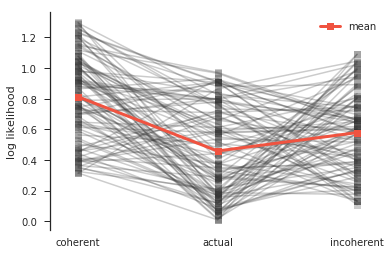

In [20]:
def plot_ll_comparison(data1, data2, data3, labels=None, lw=None, ax=None, alpha=None):
    """Plot comparison of data log likelihoods for 1-v-2 paired data."""
    
    if ax is None:
        ax = plt.gca()
    if lw is None:
        lw=1.5
        
    # stack data
    data = np.vstack((data2, data1, data3))
    
    if alpha is not None:
        plt.plot([1, 2, 3], data, c='0.2', marker='s', lw=lw, alpha=alpha);
    else:
        plt.plot([1, 2, 3], data, c='0.2', marker='s', lw=lw);

    ax.set_xlim([0.8, 3.2])
    ax.set_xticks([1,2, 3])
    ax.set_xticklabels([labels[1], labels[0], labels[2]])
    ax.set_ylabel('log likelihood')

    plt.plot([1, 2, 3], data.mean(axis=1), c=npl.colors.sweet.red, marker='s', lw=lw*2, label='mean');
    plt.legend()
    sns.despine(ax=ax)
    npl.utils.no_xticks(ax)
    ax.spines['bottom'].set_color('none')
    
n_samples = 100
fake_a = np.random.rand(n_samples)
fake_b = np.random.rand(n_samples) + 0.3
fake_c = np.random.rand(n_samples) + 0.1

data = np.vstack((fake_a, fake_b, fake_c))

plot_ll_comparison(fake_a, fake_b, fake_c, labels=['actual', 'coherent', 'incoherent'], alpha=0.25)

In [11]:
n_shuffles = 50
aggregate = dict()

for session_time, segment in gor_sessions:   
    description = (session_time, segment)
    print(description)
    aggregate[(session_time, segment)] = dict()
    
    # get spike train
    st = exp_data[session_time]['spikes']
    
    # restrict spikes to only PBEs:
    mua_spks = st[aux_data[session_time][segment]['PBEs'].support]
    
    hmm_actual = HMMSurrogate(kind='actual', 
                          st=mua_spks, 
                          num_states=num_states, 
                          ds=ds, 
                          test_size=test_size, 
                          random_state=random_state, 
                          description=description,
                          verbose=verbose)

    hmm_incoherent = HMMSurrogate(kind='incoherent', 
                                           st=mua_spks, 
                                           num_states=num_states, 
                                           ds=ds, 
                                           test_size=test_size, 
                                           random_state=random_state, 
                                           description=description,
                                           verbose=verbose)

    hmm_coherent = HMMSurrogate(kind='coherent', 
                                           st=mua_spks, 
                                           num_states=num_states, 
                                           ds=ds, 
                                           test_size=test_size, 
                                           random_state=random_state, 
                                           description=description,
                                           verbose=verbose)

    aggregate[(session_time, segment)]['hmms'] = [hmm_actual,
            hmm_incoherent,
            hmm_coherent]
    
    for nn in range(n_shuffles):
        print('starting shuffle {}'.format(nn))
        for hmm in aggregate[(session_time, segment)]['hmms']:
#             print("shuffling", hmm.label)
            hmm.shuffle()
#             print("fitting", hmm.label)
            hmm.fit()
#             print("scoring", hmm.label)

            # calculate and aggregate various gini coefficients
            hmm.score_gini(kind='tmat')
            hmm.score_gini(kind='lambda')
            hmm.score_gini(kind='tmat_arrival')
            hmm.score_gini(kind='tmat_departure')
            hmm.score_gini(kind='lambda_across_states')
            hmm.score_gini(kind='lambda_across_units')

            # calculate and aggregate bottleneck_ratios
            hmm.score_bottleneck_ratio(n_samples=20000)

        print('completed {}'.format(nn))

            # calculate and aggregate mixing time

            # calculate and aggregate spectrum (or are we only interedted in lambda2 and spectral gap?)

('16-53-46', 'short')
starting shuffle 0
completed 0
starting shuffle 1
completed 1
starting shuffle 2
completed 2
starting shuffle 3
completed 3
starting shuffle 4
completed 4
starting shuffle 5
completed 5
starting shuffle 6
completed 6
starting shuffle 7
completed 7
starting shuffle 8
completed 8
starting shuffle 9
completed 9
starting shuffle 10
completed 10
starting shuffle 11
completed 11
starting shuffle 12
completed 12
starting shuffle 13
completed 13
starting shuffle 14
completed 14
starting shuffle 15
completed 15
starting shuffle 16
completed 16
starting shuffle 17
completed 17
starting shuffle 18
completed 18
starting shuffle 19
completed 19
starting shuffle 20
completed 20
starting shuffle 21
completed 21
starting shuffle 22
completed 22
starting shuffle 23
completed 23
starting shuffle 24
completed 24
starting shuffle 25
completed 25
starting shuffle 26
completed 26
starting shuffle 27
completed 27
starting shuffle 28
completed 28
starting shuffle 29
completed 29
starting

In [21]:
jar = nel.ResultsContainer(aggregate=aggregate, description='1d gor01 sparsity measures, N=50 shuffles')
# jar.save_pkl('gor01_sparsity_all.nel')

In [15]:
np.mean(aggregate[('1-22-43', 'long')]['hmms'][0].results['bottleneck']) # actual
aggregate[('1-22-43', 'long')]['hmms'][1] # incoherent
aggregate[('1-22-43', 'long')]['hmms'][2] # coherent

In [16]:
np.mean(aggregate[('1-22-43', 'long')]['hmms'][2].results['gini_tmat_departure'])
np.mean(aggregate[('1-22-43', 'long')]['hmms'][2].results['gini_lambda'])


0.87963183205768158

In [17]:
gini_lambdas_a = []
gini_lambdas_c = []
gini_lambdas_i = []
gini_tmat_departures_a = []
gini_tmat_departures_c = []
gini_tmat_departures_i = []
bottlenecks_a = []
bottlenecks_c = []
bottlenecks_i = []

for session_time, segment in gor_sessions:
    bottlenecks_a.append(np.mean(aggregate[(session_time, segment)]['hmms'][0].results['bottleneck']))
    bottlenecks_i.append(np.mean(aggregate[(session_time, segment)]['hmms'][1].results['bottleneck']))
    bottlenecks_c.append(np.mean(aggregate[(session_time, segment)]['hmms'][2].results['bottleneck']))
    
    gini_tmat_departures_a.append(np.mean(aggregate[(session_time, segment)]['hmms'][0].results['gini_tmat_departure']))
    gini_tmat_departures_i.append(np.mean(aggregate[(session_time, segment)]['hmms'][1].results['gini_tmat_departure']))
    gini_tmat_departures_c.append(np.mean(aggregate[(session_time, segment)]['hmms'][2].results['gini_tmat_departure']))
    
    gini_lambdas_a.append(np.mean(aggregate[(session_time, segment)]['hmms'][0].results['gini_lambda']))
    gini_lambdas_i.append(np.mean(aggregate[(session_time, segment)]['hmms'][1].results['gini_lambda']))
    gini_lambdas_c.append(np.mean(aggregate[(session_time, segment)]['hmms'][2].results['gini_lambda']))
    

In [26]:
bottlenecks_a

[0.18738522372838204,
 0.19087747488192708,
 0.15760397703381718,
 0.1575616057881799,
 -2.7772969252965978,
 0.24816946463554007,
 0.22483818087064286,
 0.20401211759130913,
 0.2349443248147785,
 0.18231083196592132,
 0.2191540501445797,
 0.17915847010424174,
 0.12881220257006035,
 0.15197009124989436,
 0.24868756434134462,
 0.20211685930392306,
 0.17753244511081959,
 0.19467838634944595,
 0.24733493895260605,
 0.075237850388092622]

(0, 0.4)

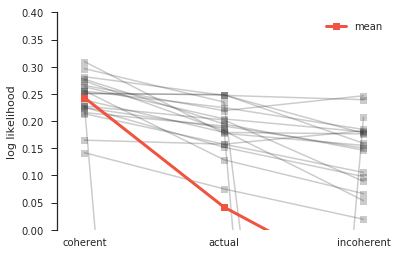

In [28]:
plot_ll_comparison(bottlenecks_a, bottlenecks_c, bottlenecks_i, labels=['actual', 'coherent', 'incoherent'], alpha=0.25)
plt.ylim(0,0.4)

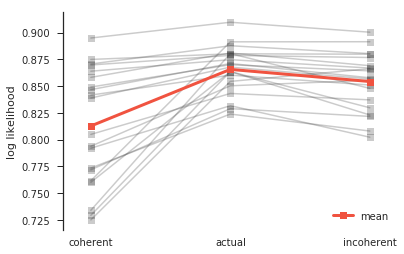

In [23]:
plot_ll_comparison(gini_tmat_departures_a, gini_tmat_departures_c, gini_tmat_departures_i, labels=['actual', 'coherent', 'incoherent'], alpha=0.25)

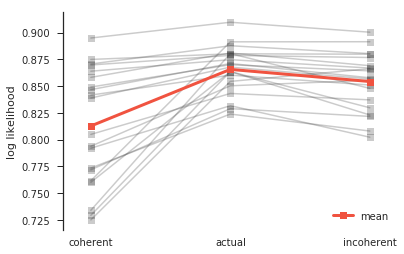

In [24]:
plot_ll_comparison(gini_tmat_departures_a, gini_tmat_departures_c, gini_tmat_departures_i, labels=['actual', 'coherent', 'incoherent'], alpha=0.25)

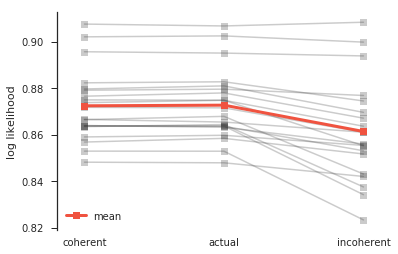

In [25]:
plot_ll_comparison(gini_lambdas_a, gini_lambdas_c, gini_lambdas_i, labels=['actual', 'coherent', 'incoherent'], alpha=0.25)